# QNN
In this notebook we will go over the basis of Quantum Neural Networks: how they are connected to CNN (Classical Neural Network), how they work and what are the possible applications.

## Estimator QNN
The EstimatorQNN takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass

In [1]:
from qiskit_machine_learning.utils import algorithm_globals
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN


algorithm_globals.random_seed = 3                                 # set a value of the seed so that results wonn't change simulation from simulation

params = [Parameter('θ_1'), Parameter('θ_2')]   

# note that Parameter is just used for visualization purposes and do not actually assing values to the parameters 


We start with a simple example: a paramatrized quantum citrcuit that acts only on one qubit 

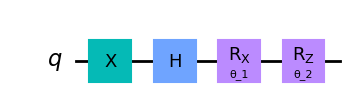

In [2]:
# create a quantum circuit that acts on one qubit 
qc = QuantumCircuit(1)
qc.x(0)
qc.h(0)
qc.rx(params[0], 0)
qc.rz(params[1], 0)
qc.draw(output = "mpl", style = "clifford")

We now need to create an observable in order to define the expectation value. If not specified otherwise EstimatorQNN will automatically consider 
\begin{equation}
O = Z \otimes Z \otimes \dots \otimes Z = Z^{\otimes n}
\end{equation}
In this case we only have $1$ qubit, so the corresponding observable would be $O = Z$. Let us change things up and use $O = Y$ instead.

In [3]:
n_qc_qubits = qc.num_qubits
observable_Y = SparsePauliOp.from_list([("Y"*n_qc_qubits, 1)])



We may now use the Estimator which takes as input the quantum circuit, the input values and the input weights. We also need to specify which kind of estimator we are working with. In this example we will be using the StateVector library

In [4]:
# create the quantum estimator using the ansatz 
estimator = Estimator()

estimator_qnn = EstimatorQNN(circuit = qc, estimator = estimator,
                             observables = observable_Y,
                             input_params = [params[0]],
                             weight_params = [params[1]],
                             )
print(estimator_qnn)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


When training a nerual network, the input parameters are given by the data set and the weights are relative to the model we are using to train the network itself. In this example we will generate both the input parameters and weights using `algorithm-globals.random.random`.

In [5]:
qnn_input_params = algorithm_globals.random.random(size = estimator_qnn.num_inputs)
qnn_weights = algorithm_globals.random.random(size = estimator_qnn.num_weights)

print("Number of features for the estimator : " , estimator_qnn.num_inputs)
print("Input : ", qnn_input_params)
print("Number of weights for the estimator : " , estimator_qnn.num_weights)
print("Weights: ", qnn_weights)


Number of features for the estimator :  1
Input :  [0.08564917]
Number of weights for the estimator :  1
Weights:  [0.23681051]


In [6]:
# apply a forward pass in the network 
estimator_qnn_f_pass = estimator_qnn.forward(input_data = qnn_input_params, weights = qnn_weights)
print("Forward pass result: ", estimator_qnn_f_pass)

# apply a forward pass for a batch
estimator_qnn_f_pass_batch = estimator_qnn.forward(input_data = [qnn_input_params, qnn_input_params], weights = qnn_weights)
print("Forward pass result for a batch: ")
print(estimator_qnn_f_pass_batch)

Forward pass result:  [[-0.22219396]]
Forward pass result for a batch: 
[[-0.24136116]
 [-0.25626126]]


In [7]:
# let us do tghe same for a bacward pass 
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(input_data = qnn_input_params,
                                                                            weights = qnn_weights)

print("Input gradient for the estimator: ", estimator_qnn_input_grad)
print("Weight gradient for the estimator: ")
print(estimator_qnn_weight_grad)

Input gradient for the estimator:  None
Weight gradient for the estimator: 
[[[-0.97209118]]]


In [8]:
estimator_qnn.input_gradients = True
# let us do tghe same for a bacward pass 
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(input_data = qnn_input_params,
                                                                            weights = qnn_weights)

print("Input gradient for the estimator: ", estimator_qnn_input_grad)
print("Weight gradient for the estimator: ")
print(estimator_qnn_weight_grad)

Input gradient for the estimator:  [[[0.]]]
Weight gradient for the estimator: 
[[[-0.97209118]]]


In [9]:
# we can also to the same with more than one observable 
O1 = SparsePauliOp.from_list([("Y"*n_qc_qubits, 1)])
O2 = SparsePauliOp.from_list([("Z"*n_qc_qubits, 1)])
O3 = SparsePauliOp.from_list([("X"*n_qc_qubits, 1)])


estimator_qnn_3 = EstimatorQNN(circuit = qc, estimator = estimator,
                             observables = [O1, O2, O3],
                             input_params = [params[0]],
                             weight_params = [params[1]],
                             )

estimator_qnn_3.input_gradients = True 
estimator_qqn_forward3 = estimator_qnn_3.forward(input_data = qnn_input_params, weights = qnn_weights)
estimator_qnn_3_igrad, estimator_qnn_3_wgrad = estimator_qnn_3.backward(
    input_data = qnn_input_params, weights = qnn_weights
)

print("Output shape forward pass QNN1: ", estimator_qnn_f_pass.shape)
print("Output shape forward pass QNN3 ", estimator_qqn_forward3.shape)
print("Output shape backward pass QNN1: ", estimator_qnn_weight_grad.shape)
print("Output shape backward pass QNN3 ", estimator_qnn_3_wgrad.shape)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Output shape forward pass QNN1:  (1, 1)
Output shape forward pass QNN3  (1, 3)
Output shape backward pass QNN1:  (1, 1, 1)
Output shape backward pass QNN3  (1, 3, 1)


We can also do the same thing using `SamplerQNN`, in a similar manner to what we have done with `Estimator`.  The former gives us the possibility to use an `interpret` function for post processing operations. In this case, when the function is provided, the`output_shape` of the result must be specified explicitly. In general, the sampler outputs a $d$ dimensional probability vector, where $d$ refers to the the number of classes.  

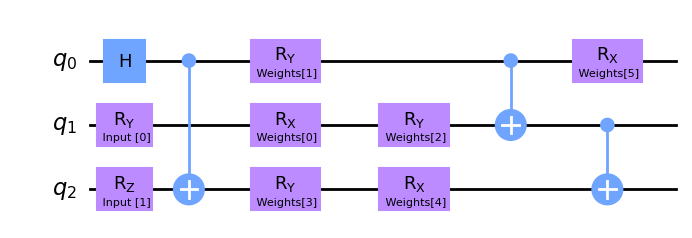

In [12]:
from qiskit.circuit import ParameterVector

input_data = ParameterVector(" Input ", length = 2)
input_weights = ParameterVector(" Weights", length = 6)

# define an ansatz using input data and input weights 
qc = QuantumCircuit(3)
qc.h(0)
qc.ry(theta = input_data[0], qubit = 1)
qc.rz(phi= input_data[1], qubit = 2)
qc.cx(control_qubit = 0, target_qubit = 2)
qc.rx(theta = input_weights[0], qubit = 1)
qc.ry(theta = input_weights[1], qubit = 0)
qc.ry(theta = input_weights[2], qubit = 1)
qc.ry(theta = input_weights[3], qubit = 2)
qc.cx(control_qubit = 0, target_qubit = 1)
qc.rx(theta = input_weights[4], qubit = 2)
qc.rx(theta = input_weights[5], qubit = 0)
qc.cx(control_qubit = 1, target_qubit = 2)

qc.draw(output = "mpl", style = "clifford")



In [21]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler

sampler  =  Sampler()
sampler_qnn = SamplerQNN(circuit  = qc, input_params = input_data, weight_params = input_weights,
                         sampler = sampler)
print(sampler_qnn)

sampler_qnn_params = algorithm_globals.random.random(size = sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(size = sampler_qnn.num_weights)

print("Sampler input params : ")
print(sampler_qnn_params)
print("Sampler input weights : ")
print(sampler_qnn_weights)


sampler_qnn_forward_pass = sampler_qnn.forward(input_data = sampler_qnn_params, weights = sampler_qnn_weights)
print("Result of forward pass : ")
print(sampler_qnn_forward_pass)

# we can do the same with a batch 

sampler_qnn_forward_pass_batch = sampler_qnn.forward([sampler_qnn_params, sampler_qnn_params], sampler_qnn_weights)
print("Result of forward pass for a batch  : ")
print(sampler_qnn_forward_pass_batch)



No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Sampler input params : 
[0.47130967 0.77327701]
Sampler input weights : 
[0.03034601 0.7069651  0.37424383 0.09085271 0.66050007 0.93146385]
Result of forward pass : 
[[0.22070312 0.13378906 0.14160156 0.21484375 0.125      0.02246094
  0.02929688 0.11230469]]
Result of forward pass for a batch  : 
[[0.21386719 0.13671875 0.12011719 0.21875    0.11328125 0.02734375
  0.02929688 0.140625  ]
 [0.24121094 0.12402344 0.12109375 0.25292969 0.09667969 0.01464844
  0.02539062 0.12402344]]


In [24]:
# we can also initialise the input gradients 
sampler_qnn.input_gradients =   True

sampler_qnn_input_grad , sampler_qnn_weights_grad = sampler_qnn.backward(input_data = sampler_qnn_params, weights = sampler_qnn_weights)

print("Sampler input gradient for params : ")
print(sampler_qnn_input_grad)
print("Sampler input gradient for weights : ")
print(sampler_qnn_weights_grad)
print("Shape of input gradient for parameters : ", sampler_qnn_input_grad.shape)
print("Shape of input gradient for weights : ", sampler_qnn_weights_grad.shape)





Sampler input gradient for params : 
[[[-0.15771484 -0.01171875]
  [ 0.04785156  0.01123047]
  [ 0.03466797  0.00390625]
  [-0.15722656  0.00097656]
  [ 0.03955078  0.        ]
  [ 0.07275391 -0.00683594]
  [ 0.08349609  0.00390625]
  [ 0.03662109 -0.00146484]]]
Sampler input gradient for weights : 
[[[-0.046875   -0.078125   -0.16552734  0.08251953 -0.14013672
   -0.16650391]
  [ 0.03369141  0.00878906  0.03515625 -0.00830078  0.05322266
    0.16259766]
  [-0.04296875 -0.00097656  0.03710938  0.01611328  0.05712891
    0.16796875]
  [ 0.02978516 -0.07861328 -0.15039062  0.0625     -0.13964844
   -0.1640625 ]
  [ 0.05761719  0.06298828  0.03564453 -0.08398438  0.14453125
    0.02978516]
  [-0.03173828  0.00830078  0.08544922 -0.00244141 -0.0546875
   -0.03710938]
  [ 0.04833984  0.00244141  0.08544922 -0.01025391 -0.06542969
   -0.02978516]
  [-0.04785156  0.07519531  0.03710938 -0.05615234  0.14501953
    0.03710938]]]
Shape of input gradient for parameters :  (1, 8, 2)
Shape of input